# SQL project

This project requires writing several SQL queries to explore the data that are in the tables of the `stackoverflow` schema. We will connect to the database using SQLAlchemy.

**Note**: in order to preserve confidential information, the information for connecting to the database is hidden.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

# import dictionary containing db connection info
from configs import db_config

### Configuration for database connection

In [2]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'], # user name
    db_config['pwd'],  # password
    db_config['host'], # host
    db_config['port'], # port
    db_config['db'],   # database name
)

Creating a connection

In [3]:
engine = create_engine(connection_string) 

Sample database query:

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Problem 1

Print the total sum of post views for each month of 2008. If there is no data for any month in the database, you can skip this month. Sort the result in descending order of the total number of views.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [6]:
query = '''
SELECT DATE_TRUNC('month', creation_date) AS month_date, 
    SUM(views_count) AS total_views
FROM stackoverflow.posts
WHERE EXTRACT('year' FROM creation_date) = 2008
GROUP BY DATE_TRUNC('month', creation_date)
ORDER BY total_views DESC
'''

result_df = pd.read_sql_query(query, con=engine)
result_df

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


The smallest number of views in the first month of the present (in July). This may be due to the fact that the data started to be collected not from the first day.

The peak of views is observed in September. This can probably be explained by the beginning of the academic year for students and the end of the summer vacation period for working people. In the following months, the number of views decreases.

# Problem 2

Print the names of the most active users who gave more than 100 answers in the first month after registration (including the day of registration). Do not take into account the questions asked by users. Print the number of unique `user_id` values for each user name. Sort the result by the field with names in lexicographic order.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [7]:
uery = '''
SELECT us.display_name,
    COUNT(DISTINCT us.id)
    
FROM stackoverflow.users AS us
JOIN stackoverflow.posts AS p ON p.user_id = us.id
JOIN stackoverflow.post_types AS pt ON pt.id = p.post_type_id

WHERE pt.type = 'Answer' 
    AND p.creation_date::date BETWEEN us.creation_date::date AND us.creation_date::date + INTERVAL '1 month'
    
GROUP BY us.display_name
HAVING COUNT(p.id) > 100
ORDER BY us.display_name
'''

result_df = pd.read_sql_query(query, con=engine)
result_df

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
74,lomaxx,1
75,mattlant,1
76,paxdiablo,1
77,tvanfosson,1


Let's see if there are any anomalies in the data.

In [8]:
result_df.sort_values(by='count', ascending=False).head(30)

,display_name,count
45,Matt,29
10,Chris,29
14,Dan,21
64,Tom,19
41,Mark,17
50,Nick,16
33,Josh,16
7,Brian,15
56,Rob,15
21,Greg,12


Interestingly, a higher number of responses are from users with short first names. Low-active users are mostly given a last name and first name or a longer first name. This may be due to the fact that there is no restriction on the uniqueness of the "name" on the site, so names of different users may be repeated, especially if they are short.

# Problem 3

Print the number of posts for 2008 by month. Select posts from users who registered in September 2008 and made at least one post in December of the same year. Sort the table by descending month value.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [9]:
query = '''
WITH tt AS 
    (SELECT us.id AS user_id
    FROM stackoverflow.users AS us
    JOIN stackoverflow.posts AS p ON us.id = p.user_id
    WHERE DATE_TRUNC('month', us.creation_date) = '2008-09-01'
        AND DATE_TRUNC('month', p.creation_date) = '2008-12-01')
    
SELECT DATE_TRUNC('month', creation_date) AS month,
    COUNT(id)
FROM stackoverflow.posts
WHERE user_id IN 
    (SELECT user_id FROM tt)
GROUP BY DATE_TRUNC('month', creation_date)
ORDER BY month DESC
'''

result_df = pd.read_sql_query(query, con=engine)
result_df

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


The number of posts in August seems anomalous, given that the query selected users who had only registered in September. This may be due to some error in the initial data collection or to different time zones.

# Problem 4

Using the post data, output several fields:

- ID of the user who wrote the post;
- the date the post was created;
- the number of views of the current post;
- the sum of views of the author's posts with accumulation.

The data in the table should be sorted by ascending order of user IDs, and data about the same user - by ascending order of post creation date.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [10]:
query = '''
SELECT user_id,
    creation_date,
    views_count, 
    SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date) AS cumulative_count
FROM stackoverflow.posts
ORDER BY user_id, creation_date
'''

result_df = pd.read_sql_query(query, con=engine)
result_df

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Problem 5

Find the average number of user posts per day for August 2008. Select data on users who published more than 120 posts in August. Do not count the days with no posts. 

Sort the result in ascending order of the average number of posts. You don't need to round the values.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [11]:
query = '''
WITH tt AS
    (SELECT user_id,
        creation_date::date,
        COUNT(id) AS post_count
    FROM stackoverflow.posts
    WHERE DATE_TRUNC('month', creation_date) = '2008-08-01'
    GROUP BY user_id, creation_date::date)

SELECT user_id, 
    AVG(post_count) AS avg_daily
FROM tt
GROUP BY user_id
HAVING SUM(post_count) > 120
ORDER BY avg_daily
'''

result_df = pd.read_sql_query(query, con=engine)
result_df

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Problem 6

On average, how many days between December 1 and December 7, 2008 did users interact with the platform? For each user, select the days on which he or she published at least one post. You need to get a single integer - don't forget to round the result.

In [12]:
query = '''
WITH tt AS
    (SELECT user_id, 
        COUNT(DISTINCT creation_date::date) AS days
    FROM stackoverflow.posts
    WHERE creation_date::date BETWEEN '2008-12-01' AND '2008-12-07'
    GROUP BY user_id)

SELECT CAST(AVG(days) AS integer) AS result
FROM tt
'''

result_df = pd.read_sql_query(query, con=engine)
result_df

,result
0,2


On average, each user was active for 2 days (asking or answering questions) during a given week.

# Problem 7

Print the activity history of each user in the following form: user ID, post publication date. Sort the output in ascending order of user IDs, and for each user - in ascending order of publication date.

Add a new field to the table: for each post it will contain the name of the month of the penultimate publication of the user relative to the current one. If there is no such publication, specify `NULL`.  Python will automatically change `NULL` to `None`, but you don't need to convert `None` values additionally.

Look closely at the sample table: for the first two posts, there is no penultimate publication, but starting with the third post, the new field includes the desired month. For the next user, the first two entries of the `second_last_month` field will also include `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [13]:
query = '''
SELECT user_id,
    creation_date, 
    LAG(TO_CHAR(creation_date, 'Month'), 2) OVER(PARTITION BY user_id ORDER BY creation_date) AS second_last_month
FROM stackoverflow.posts
ORDER BY user_id, creation_date
'''

result_df = pd.read_sql_query(query, con=engine)
result_df

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Problem 8

Calculate the analog Retention Rate by month for StackOverflow users. Combine users into cohorts by the month of their first post. Determine the Retention Rate by the availability of a post in the current month.

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [14]:
query = '''
WITH first_dates AS
  (SELECT DISTINCT user_id,
          FIRST_VALUE(DATE_TRUNC('month', creation_date)) OVER (PARTITION BY user_id ORDER BY creation_date) AS first_date
   FROM stackoverflow.posts),
   
cohorts AS 
(SELECT user_id,
    first_date::date AS cohort_dt,
    COUNT(user_id) OVER (PARTITION BY first_date) AS cohort_users_cnt
FROM first_dates),

sessions AS 
(SELECT user_id,
        DATE_TRUNC('month', creation_date) AS session_date
FROM stackoverflow.posts
GROUP BY user_id, DATE_TRUNC('month', creation_date))

SELECT c.cohort_dt::date,
    s.session_date::date,
    COUNT(c.user_id) AS users_cnt,
    c.cohort_users_cnt,
    ROUND(COUNT(c.user_id)::numeric * 100 / cohort_users_cnt, 2) AS retention_rate
FROM cohorts AS c
JOIN sessions AS s ON c.user_id = s.user_id
GROUP BY c.cohort_dt, s.session_date, c.cohort_users_cnt

'''

result_df = pd.read_sql_query(query, con=engine)
result_df

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Retention Rate heatmap:

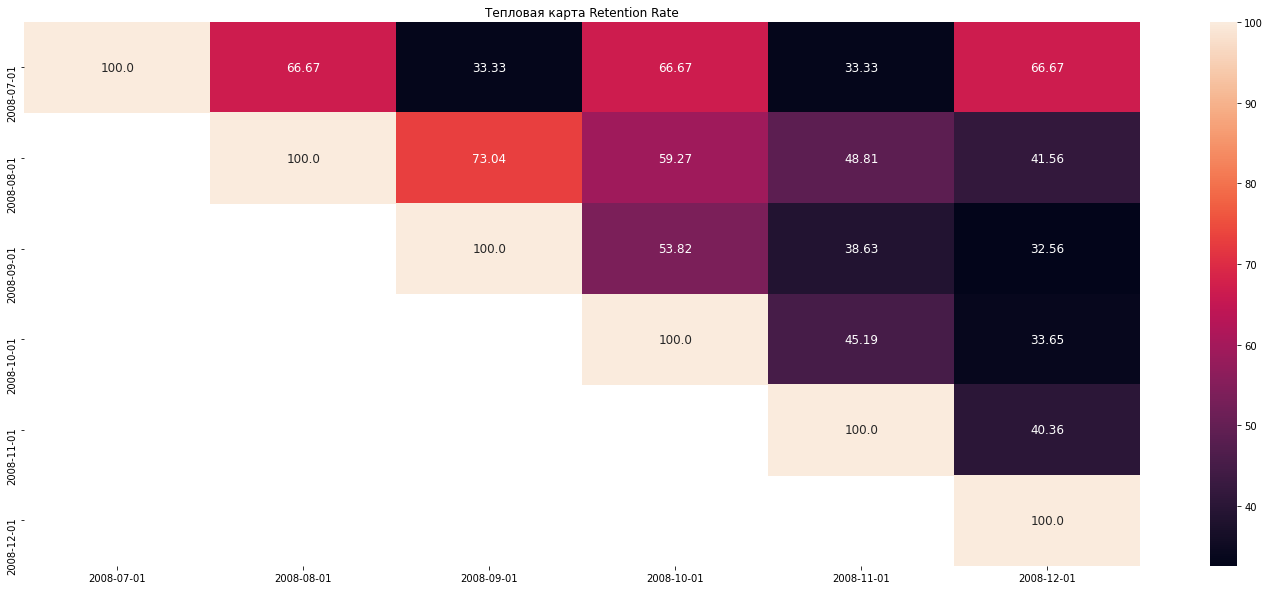

In [15]:
# pivot table with results
retention = result_df.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# heatmap
plt.figure(figsize=(25, 10)) 
sns.heatmap(retention, 
            annot=True, 
            annot_kws={'fontsize':12}, 
            fmt='') 
plt.title('Тепловая карта Retention Rate')

plt.show()

In [16]:
result_df.groupby('cohort_dt')['users_cnt'].first()

cohort_dt
2008-07-01       3
2008-08-01    2151
2008-09-01    7678
2008-10-01    3629
2008-11-01    2852
2008-12-01    2536
Name: users_cnt, dtype: int64

The July 2008 cohort seems to be the most uninformative: it includes only 3 people, which is why the retention rate varies so unevenly over time. In other cases, the % of remaining users in the cohort decreases with each successive month, with the biggest jump observed when moving from the first month to the second. It is probably common for a user to register, be active in the same month, find an answer to a question of interest, and then leave.

The highest retention rate for the second month is for users of the cohort from August. This may also be due to the beginning of the school year, since past queries have shown that the number of post views in September is maximal.

Further, the older the cohort, the more the retention rate decreases. For example, the % of remaining active users from November to the second month is only 40%

# Problem 9


By how much percent did the number of posts change each month from September 1 to December 31, 2008? Display a table with the following fields:

- month number;
- the number of posts for the month;
- a percentage that shows how much the number of posts in the current month changed from the previous month.

If there are fewer posts, the percentage should be negative; if there are more posts, the percentage should be positive. Round the percentage value to two decimal places.

Recall that when dividing one integer by another in PostgreSQL, the result will be an integer rounded down to the nearest integer. To avoid this, convert the divisor to the `numeric` type.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [17]:
query = '''
WITH tt AS
    (SELECT EXTRACT(MONTH FROM creation_date) AS creation_month,
    COUNT(id) AS post_count
    FROM stackoverflow.posts
    WHERE creation_date::date BETWEEN '2008-09-01' AND '2008-12-31'
    GROUP BY EXTRACT(month FROM creation_date))

SELECT creation_month::integer,
    post_count, 
    ROUND((post_count::numeric / LAG(post_count) OVER (ORDER BY creation_month) - 1) * 100, 2) AS percentage
FROM tt
'''

result_df = pd.read_sql_query(query, con=engine)
result_df.head()

,creation_month,post_count,percentage
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


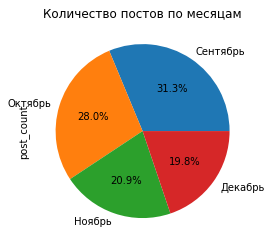

In [18]:
# pie chart
result_df['post_count'].plot(kind='pie', labels=['Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'], autopct='%1.1f%%')
plt.title('Количество постов по месяцам')
plt.show()

# Problem 10

Unload the activity data of the user who has published the most posts over time. Output the data for October 2008 in this form:

- week number;
- date and time of the last post published this week.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [19]:
query = '''
WITH tt AS
    (SELECT user_id,
        COUNT(id) AS post_count
    FROM stackoverflow.posts
    GROUP BY user_id
    ORDER BY post_count DESC
    LIMIT 1)
    
SELECT DISTINCT EXTRACT(WEEK FROM creation_date)::integer AS week_creation,
    MAX(creation_date) OVER (PARTITION BY EXTRACT(WEEK FROM creation_date))
    FROM stackoverflow.posts
    WHERE user_id = (SELECT user_id FROM tt)
        AND DATE_TRUNC('month', creation_date) = '2008-10-01'
'''

result_df = pd.read_sql_query(query, con=engine)
result_df.head()

,week_creation,max
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01
